## Dynamic Risk Budgeting

In this notebook, we will move to some more sophisticated allocators.


In [15]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
n_scenarios = 500
rates, zc_prices = erk.cir(10,n_scenarios=n_scenarios, b=0.03, r_0=0.03,sigma=0.02)
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07,sigma=0.15)

In [17]:
rets_eq = price_eq.pct_change()
rets_eq.iloc[0] = 0 #first row is returned as a NaN. We should set it to 0, as there is no return.
rets_zc = zc_prices.pct_change().dropna()
rets_7030 = erk.bt_mix(rets_eq,rets_zc,allocator=erk.fixedmix_allocator,w1=0.7)

pd.concat([erk.terminal_stats(rets_zc,name="ZC",floor=0.75),
           erk.terminal_stats(rets_eq,name="Equities",floor=0.75),
           erk.terminal_stats(rets_7030, name="70/30 mix",floor=0.75)]).round(2)

,Mean,STD,P_breach,E_short,P_reach,E_surplus
ZC,1.34,0.00,NaN,NaN,NaN,NaN
Equities,1.96,0.95,0.03,0.11,NaN,NaN
70/30 mix,1.75,0.58,0.01,0.05,NaN,NaN


### Floor allocator



We will consider two new allocators. The first one is called **floor allocator**, which finds its roots in CPPI strategy:

In [18]:
def floor_allocator(psp_r,ghp_r,floor,zc_prices,m=3):
    
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside 
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorith by investing a multiple
    of the cushion in the PSP.
    Returns a DataFrame with the same shape as the PSP/GHP representing the weights in the PSP
    """
    
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC prices must have the same shape")
    n_steps,n_scenarios = psp_r.shape
    account_value = np.repeat(1,n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame (index=psp_r.index,columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] #PV of Floor assuming todays'rates and flat Yield Curve
        cushion = (account_value-floor_value)/account_value #gives cushion as percentage.
        psp_w = (m*cushion).clip(0,1) # values of m*cushion smaller than become 0 and values bigger than 1 become 1.
        #It is a way to bound the weights
        ghp_w = 1- psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        #recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
        
    return w_history

In [19]:
rets_75 = erk.bt_mix(rets_eq,rets_zc,allocator=erk.floor_allocator,floor=0.75,zc_prices=zc_prices[1:])

pd.concat([erk.terminal_stats(rets_zc,name="ZC",floor=0.75),
           erk.terminal_stats(rets_eq,name="Equities",floor=0.75),
           erk.terminal_stats(rets_7030,name="70/30 mix",floor=0.75),
           erk.terminal_stats(rets_75, name="Floor75",floor=0.75)]).round(2)

,Mean,STD,P_breach,E_short,P_reach,E_surplus
ZC,1.34,0.00,NaN,NaN,NaN,NaN
Equities,1.96,0.95,0.03,0.11,NaN,NaN
70/30 mix,1.75,0.58,0.01,0.05,NaN,NaN
Floor75,1.93,0.96,NaN,NaN,NaN,NaN


As we can see, the performance of the floor allocator is *extremely* good, as it has almost the same mean return as a 100% equities portfolio and 0 floor breaches. Of course, if m were higher, we might find some breaches, but as long as it is not extremely big, you should still be safe. As an example, let's try m=5:

In [20]:
rets_75m5 = erk.bt_mix(rets_eq,rets_zc,allocator=erk.floor_allocator,floor=0.75,zc_prices=zc_prices[1:],m=5)
erk.terminal_stats(rets_75m5, name="Floor75, m=5",floor=0.75)

,Mean,STD,P_breach,E_short,P_reach,E_surplus
"Floor75, m=5",1.939459,0.964576,0.002,0.000911,NaN,NaN


As you can see the breaches are extremely rate and very small.

### Drawdown Allocator


The second allocator we will work with is the **drawdown allocator**. It is very similar to the floor allocator (it also follows the CPPI strategy), but in this case the floor is updated to follow the maximum drawdown we would allow at any time.

In [21]:
def drawdown_allocator(psp_r,ghp_r,maxdd, m=3):
    
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside 
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP.
    Floor is based on the maximum drawdown you would never want to meet at any time (this is the change
    with respect to floor_allocator)
    Returns a DataFrame with the same shape as the PSP/GHP representing the weights in the PSP
    """
   
    n_steps,n_scenarios = psp_r.shape
    account_value = np.repeat(1,n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    peak_value = np.repeat(1,n_scenarios)
    w_history = pd.DataFrame (index=psp_r.index,columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = (1-maxdd)*peak_value #Floor is based on previous peak. 
        cushion = (account_value-floor_value)/account_value #gives cushion as percentage.
        psp_w = (m*cushion).clip(0,1) # values of m*cushion smaller than become 0 and values bigger than 1 become 1.
        #It is a way to bound the weights
        ghp_w = 1- psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        #recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        peak_value = np.maximum(peak_value,account_value) #peak must be updated to establish new floor
        w_history.iloc[step] = psp_w
        
    return w_history


In this case, we cannot use the zero-coupon bond, because we need something that has very short duration (for instance, cash). The reason why is because the floor has to be constantly updated. For the floor allocator it was actually updated too, but only to take into account the discount rate of the dollar, so in some sense, the floor was fixed.

In [22]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index,columns=rets_eq.columns) #DataFrame with unique
#value in all positions 
rets_maxdd25 = erk.bt_mix(rets_eq,rets_cash,allocator=erk.drawdown_allocator,maxdd=.25)




In [23]:
pd.concat([erk.terminal_stats(rets_zc,name="ZC",floor=0.75),
           erk.terminal_stats(rets_eq,name="Equities",floor=0.75),
           erk.terminal_stats(rets_7030,name="70/30 mix",floor=0.75),
           erk.terminal_stats(rets_75, name="Floor75",floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25",floor=0.75)]).round(2)

,Mean,STD,P_breach,E_short,P_reach,E_surplus
ZC,1.34,0.00,NaN,NaN,NaN,NaN
Equities,1.96,0.95,0.03,0.11,NaN,NaN
70/30 mix,1.75,0.58,0.01,0.05,NaN,NaN
Floor75,1.93,0.96,NaN,NaN,NaN,NaN
MaxDD25,1.63,0.52,NaN,NaN,NaN,NaN


As you can see, the returns are lower than with the floor allocator, but the volatility is heavily reduced. For the floor allocator you botain a Sharpe ratio of around 2, but for the max drawdown allocator, the Sharpe ratio is approximately 3.3.

Let's plot the distribution of the final compounded returns for all the cases we've seen:

C:\Users\jackt\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jackt\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jackt\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

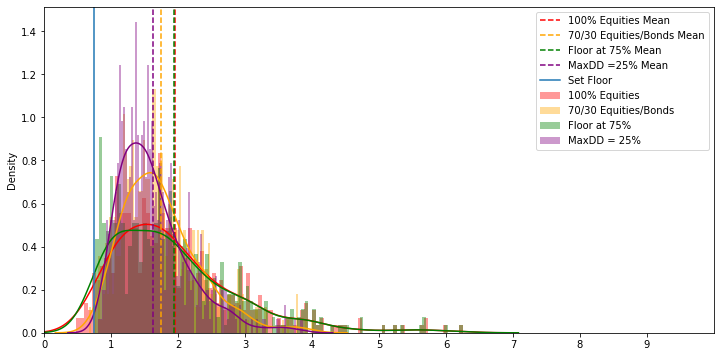

In [24]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030 = erk.terminal_values(rets_7030)
tv_floor75 = erk.terminal_values(rets_75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

#Plot

plt.figure(figsize=(12,6))
sns.distplot(tv_eq,color="red",label="100% Equities",bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red", label= "100% Equities Mean")
sns.distplot(tv_7030,color="orange",label="70/30 Equities/Bonds",bins=100)
plt.axvline(tv_7030.mean(), ls="--", color="orange", label= "70/30 Equities/Bonds Mean")
sns.distplot(tv_floor75,color="green",label="Floor at 75%",bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green", label= "Floor at 75% Mean")
sns.distplot(tv_maxdd25,color="purple",label="MaxDD = 25%",bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="purple", label= "MaxDD =25% Mean")
plt.xticks(np.arange(0, 10, step=1))
plt.axvline(0.75,label="Set Floor")
plt.xlim(0,10)
plt.legend()

As you can see, the floor allocator does a tremendously good job as a cutoff. As you can see, in this case the distribution does not have high peaks, but a more or less flat density around 0.75-2 returns. On the other hand, the MaxDD allocator also does a good job at preventing the floor breach, but the distribution is more leptokurtic, with less big returns than any of the other allocators.

### Drawdown constraint with Historical Data

In [25]:
rets_tmi = erk.get_total_market_index_returns()["1990":]


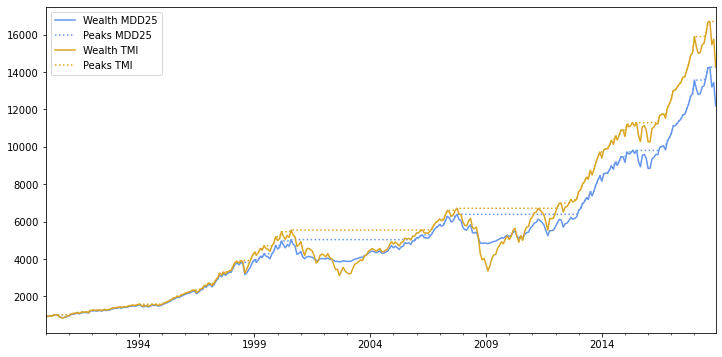

In [26]:
cashrate=0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0]) #1column dataframe
rets_tmi.columns=[0] #Eliminate column name to avoid errors
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi),rets_cash,allocator=erk.drawdown_allocator, maxdd=0.25,m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])


dd_tmi = erk.drawdown(rets_tmi[0])


ax= dd_25["Wealth"].plot(figsize=(12,6),ls="-",color="cornflowerblue",label="Wealth MDD25")
dd_25["Peaks"].plot(ax=ax,ls=":",color="cornflowerblue",label="Peaks MDD25")
dd_tmi["Wealth"].plot(ax=ax,ls="-",color="goldenrod",label="Wealth TMI")
dd_tmi["Peaks"].plot(ax=ax,ls=":",color="goldenrod",label="Peaks TMI")
plt.legend()

As you can see, the max drawdown strategy prevents many losses, such as the Dot-Com Bubble or the 2009. However, this also affects the potential gains. Again, you can see there is a trade-off between risk and gains. WE can have a look at some stats:

In [27]:
concat = pd.concat([rets_tmi,rets_maxdd25[0]],axis=1)
concat.columns = ["TMI","MaxDD"]
erk.summarize_stats(concat)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
TMI,0.096058,0.145419,-0.668827,4.247282,0.066949,0.093422,0.441951
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.073855,0.518327


We can confirm that with the MaxDD, the annualized return is worse, but the volatility, VaR and CVaR are way better. We can also check the maximum drawdown that happened in both cases:

In [28]:
print(dd_25["Drawdown"].min(),dd_tmi["Drawdown"].min())

-0.24421185188073447 -0.49994347511475795


Obviously, the protection against drawdown is _much_ better with the drawdown allocator.